# Food Delivery Time Prediction Model
## Albert Hunduza

***** importing dependencies *****

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

***** importing dataset *****

In [2]:
deliv_df = pd.read_csv('deliverytimehistory.txt')
deliv_df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min)
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24
1,B379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33
2,5D6D,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26
3,7A6A,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21
4,70A2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30


***** pre-processing dataset *****

* We start by dropping the ID column since it doesn't contain any useful information

In [3]:
# dropping the ID column
deliv_df.drop('ID', axis=1, inplace=True)
deliv_df.head()

,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min)
0,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24
1,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33
2,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26
3,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21
4,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30


* Next we can perform some feature engineering to help our model get more context
    - we add a column for distance as we did during EDA. We employ the geopy library that can calculate accurate distances given latitudes and longitudes

In [4]:
from geopy.distance import geodesic

# Calculate the distance between restaurant and delivery location
deliv_df['Distance'] = deliv_df.apply(lambda row: geodesic((row['Restaurant_latitude'], row['Restaurant_longitude']),
                                                            (row['Delivery_location_latitude'], row['Delivery_location_longitude'])).kilometers, axis=1)
deliv_df.head()

,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min),Distance
0,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24,3.020737
1,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33,20.143737
2,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26,1.549693
3,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21,7.774497
4,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30,6.197898


* Now we need to handle the non numerical columns
    - Using the categorical features as is would not be suitable since the Deep Learning Model would not be able to interpret them properly
    - We will use one hot encoding for the Type_of_order and Type_of_vehicle because they have low cardinality and are not ordered in any way
    - The Delivery_person_ID is somewhat more complicated since it has high cardinality so one hot encoding would create a highly dimensional and sparse feature space
    - Consequently, we will use feature hashing in this case

In [5]:
# Perform one-hot encoding on categorical columns
deliv_df_encoded = pd.get_dummies(deliv_df, columns=["Type_of_vehicle", "Type_of_order"])

# Display the encoded DataFrame
deliv_df_encoded.head()


,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_taken(min),Distance,Type_of_vehicle_bicycle,Type_of_vehicle_electric_scooter,Type_of_vehicle_motorcycle,Type_of_vehicle_scooter,Type_of_order_Buffet,Type_of_order_Drinks,Type_of_order_Meal,Type_of_order_Snack
0,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,24,3.020737,0,0,1,0,0,0,0,1
1,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,33,20.143737,0,0,0,1,0,0,0,1
2,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,26,1.549693,0,0,1,0,0,1,0,0
3,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,21,7.774497,0,0,1,0,1,0,0,0
4,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,30,6.197898,0,0,0,1,0,0,0,1


In [6]:
from sklearn.feature_extraction import FeatureHasher

# Create an instance of FeatureHasher
hasher = FeatureHasher(n_features=3, input_type='string')

# Extract the Delivery_person_ID column as a list of strings
delivery_person_ids = deliv_df_encoded['Delivery_person_ID'].astype(str).tolist()

# Apply feature hashing to the Delivery_person_ID column
hashed_features = hasher.transform(delivery_person_ids)

# Convert the hashed features to a NumPy array
hashed_features_array = hashed_features.toarray()

# Create a new DataFrame with the hashed features
hashed_df = pd.DataFrame(hashed_features_array, columns=['hashed_feature_{}'.format(i) for i in range(3)])

# Drop the original Delivery_person_ID column
deliv_df_encoded.drop('Delivery_person_ID', axis=1, inplace=True)

# Concatenate the hashed DataFrame with the original DataFrame
processed_df = pd.concat([deliv_df_encoded, hashed_df], axis=1)
processed_df.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_taken(min),Distance,Type_of_vehicle_bicycle,Type_of_vehicle_electric_scooter,Type_of_vehicle_motorcycle,Type_of_vehicle_scooter,Type_of_order_Buffet,Type_of_order_Drinks,Type_of_order_Meal,Type_of_order_Snack,hashed_feature_0,hashed_feature_1,hashed_feature_2
0,37,4.9,22.745049,75.892471,22.765049,75.912471,24,3.020737,0,0,1,0,0,0,0,1,4.0,-1.0,1.0
1,34,4.5,12.913041,77.683237,13.043041,77.813237,33,20.143737,0,0,0,1,0,0,0,1,2.0,-1.0,-1.0
2,23,4.4,12.914264,77.678400,12.924264,77.688400,26,1.549693,0,0,1,0,0,1,0,0,2.0,-2.0,0.0
3,38,4.7,11.003669,76.976494,11.053669,77.026494,21,7.774497,0,0,1,0,1,0,0,0,3.0,0.0,0.0
4,32,4.6,12.972793,80.249982,13.012793,80.289982,30,6.197898,0,0,0,1,0,0,0,1,2.0,-2.0,0.0


* Finally, we have to split our dataset into the train and test set

In [7]:
from sklearn.model_selection import train_test_split

# Separate the features and target variable
X = processed_df.drop('Time_taken(min)', axis=1)
y = processed_df['Time_taken(min)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

***** training the model *****

* We will use Pytorch to train the model

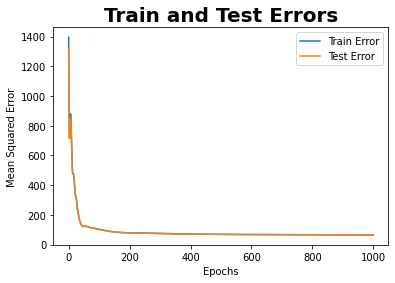

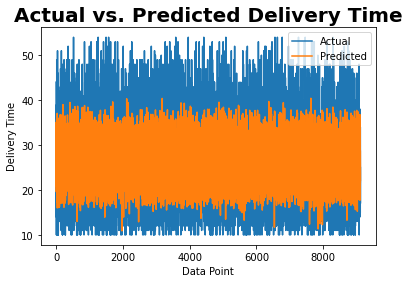

RMSE: 8.06638129307327


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error

# Check if CUDA is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64) # 64 neurons in the first hidden layer
        self.fc2 = nn.Linear(64, 32) # 32 neurons in the second hidden layer
        self.fc3 = nn.Linear(32, 1) # 1 output neuron
    
    def forward(self, x):
        x = torch.relu(self.fc1(x)) # ReLU activation function for the first two hidden layers
        x = torch.relu(self.fc2(x)) # ReLU activation function for the first two hidden layers
        x = self.fc3(x) # Linear activation function for the output layer
        return x

# Create an instance of the model
model = NeuralNetwork(input_size=X_train.shape[1]).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert the data to PyTorch tensors and move to the device
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

# Lists to store the training and testing errors
train_errors = []
test_errors = []

# Train the model with early stopping criterion
best_loss = float('inf')
patience = 50  # Number of epochs to wait for improvement
early_stop_counter = 0
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()

    # Calculate training error
    model.eval()
    with torch.no_grad():
        train_predictions = model(X_train_tensor).squeeze()
        train_error = mean_squared_error(y_train_tensor.cpu(), train_predictions.cpu())

    # Calculate testing error
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor).squeeze()
        test_error = mean_squared_error(y_test, test_predictions.cpu())

    # Record errors
    train_errors.append(train_error)
    test_errors.append(test_error)

    # Check early stopping criterion
    if test_error < best_loss:
        best_loss = test_error
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch} due to no improvement.')
            break

# Calculate RMSE
rmse = np.sqrt(test_errors[-1])

# Plot train and test errors
num_data_points = len(train_errors)
fig_size = (20, 10) if num_data_points <= 100 else (30, 10) if num_data_points <= 1000 else (40, 10)

plt.rcParams['figure.figsize'] = fig_size
plt.plot(range(len(train_errors)), train_errors, label='Train Error')
plt.plot(range(len(test_errors)), test_errors, label='Test Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Train and Test Errors', fontsize=20, weight='bold')
plt.show()

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.squeeze().cpu().numpy()

# Plot y_test and y_pred values

# Set the percentage of data points to plot
plot_percentage = 1.0

# Calculate the number of data points to plot
num_points = int(len(y_test) * plot_percentage)

# Generate indices for the sampled data points
indices = range(num_points)

# Plot y_test and y_pred values for the sampled data points
fig, ax = plt.subplots()
ax.plot(indices, y_test[:num_points], label='Actual')
ax.plot(indices, y_pred[:num_points], label='Predicted')
ax.set_xlabel('Data Point')
ax.set_ylabel('Delivery Time')
ax.set_title('Actual vs. Predicted Delivery Time', fontsize=20, weight='bold')
ax.legend()
plt.show()

# report final RMSE on the test set
print("RMSE:", rmse)

* After training the model and evaluating it, we get a low RMSE of 8.
    - However, since the model still makes false predictions quite a lot and there is no uncertainty quantification
    - This makes the model less useful for decision making and, if it were deployed on an e-commerce platform, less reliably informative to customers
    - This is the problem we will attempt to solve with Conformalized Quantile Regression

***** training model with Conformalized Quantile Regression *****

In [9]:
# importing more dependencies
import warnings
from lightgbm import LGBMRegressor
from matplotlib.offsetbox import AnnotationBbox, TextArea
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import randint, uniform
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split

from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)
from mapie.quantile_regression import MapieQuantileRegressor, MapieRegressor
from mapie.subsample import Subsample

# Set the random state for reproducibility
random_state = 42
rng = np.random.default_rng(random_state)
round_to = 3

warnings.filterwarnings("ignore")

* We start by splitting our Training set into a training set and calibration set using a 50/50 split

In [10]:
# further split the training set into training and calibration sets
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, random_state=random_state)

* We start by optimizing the base model to reduce our prediction error. 
    - We will use the class:`~lightgbm.LGBMRegressor` in the quantile setting. 
    - The optimization is performed using :class:`~sklearn.model_selection.RandomizedSearchCV`
    - This finds the optimal model to predict the house prices.



In [11]:
# optimizing the model
estimator = LGBMRegressor(objective='quantile', alpha=0.5, random_state=random_state) # alpha=0.5 for median
params_distributions = dict(num_leaves=randint(low=10, high=50), max_depth=randint(low=3, high=20), n_estimators=randint(low=50, high=300), learning_rate=uniform()) # define the parameters to search
optim_model = RandomizedSearchCV(estimator, param_distributions=params_distributions, n_jobs=-1, n_iter=100, cv=KFold(n_splits=5, shuffle=True), verbose=-1) # define the search
optim_model.fit(X_train, y_train) # perform the search
estimator = optim_model.best_estimator_ # set the best estimator

* We will now use MAPIE to return the predictions and prediction intervals.
  - We will use a miscoverage rate $\alpha=0.1$, this means a target coverage of 0.9 
  - this parameter needs to be initialized directly when setting: 
    - :class:`~mapie.quantile_regression.MapieQuantileRegressor` and when using
    - :class:`~mapie.regression.MapieRegressor`, it needs to be set in the``predict``.
  -Note that for the CQR, there are two options for ``cv``:

    - ``cv="split"`` (by default), the split-conformal where MAPIE trains the model on a training set and then calibrates on the calibration set.
    - ``cv="prefit"`` meaning that you can train your models with the correct quantile values (must be given in the following order: $(\alpha, 1-(\alpha/2), 0.5)$ and given to MAPIE as an iterable object. (Check the examples for how to use prefit in MAPIE)

* Additionally, note that there is a list of accepted models by:
    - class:`~mapie.quantile_regression.MapieQuantileRegressor`
    - (``quantile_estimator_params``) and that we will use symmetrical residuals

In [12]:
# gettting the predictions

def sort_y_values(y_test, y_pred, y_pis):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound


STRATEGIES = {"cqr": {"method": "quantile", "cv": "split", "alpha": 0.1}} # defining parameters for cqr
y_pred, y_pis = {}, {} # defining dictionaries to store the results
y_test_sorted, y_pred_sorted, lower_bound, upper_bound = {}, {}, {}, {}
coverage, width = {}, {} 
for strategy, params in STRATEGIES.items():
    if strategy == "cqr":
        mapie = MapieQuantileRegressor(estimator, **params)
        mapie.fit(X_train, y_train, X_calib=X_calib, y_calib=y_calib)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test)
    else:
        mapie = MapieRegressor(estimator, **params)
        mapie.fit(X_train, y_train)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test, alpha=0.2)
    (
        y_test_sorted[strategy],
        y_pred_sorted[strategy],
        lower_bound[strategy],
        upper_bound[strategy]
    ) = sort_y_values(y_test, y_pred[strategy], y_pis[strategy])
    coverage[strategy] = regression_coverage_score(
        y_test,
        y_pis[strategy][:, 0, 0],
        y_pis[strategy][:, 1, 0]
        )
    width[strategy] = regression_mean_width_score(
        y_pis[strategy][:, 0, 0],
        y_pis[strategy][:, 1, 0]
        )

* Having attained the predictions and prediction intervals we will now create a dataframe of the results

In [13]:
lower_bound = y_pis['cqr'][:, 0, 0]  # Extract lower bound values
upper_bound = y_pis['cqr'][:, 1, 0]  # Extract upper bound values

# Create DataFrame
df = pd.DataFrame({'Lower Bound': lower_bound, 'Upper Bound': upper_bound, 'Y_pred': y_pred['cqr']})

# Reset the index of y_test and drop the old index
ytest_reset = y_test.reset_index(drop=True)  # Reset the index of df2 and drop the old index

# Concatenate ytest_reset and df
results_df = pd.concat([df, ytest_reset], axis=1)

# Display the first five rows of results_df
results_df.head()

,Lower Bound,Upper Bound,Y_pred,Time_taken(min)
0,17.884836,49.386881,30.170877,44
1,17.951842,48.819300,29.804004,41
2,30.889557,43.638539,36.347781,39
3,17.928378,49.474884,29.603341,38
4,14.101120,41.387006,24.475836,38


* Next we will get some new columns with key result details

In [14]:
# create new column to show if the actual value is within the prediction interval
results_df['Within_Prediction_Interval'] = np.where((results_df['Time_taken(min)'] >= results_df['Lower Bound']) & (results_df['Time_taken(min)'] <= results_df['Upper Bound']), 'within', 'outside')

# create new column to show size of prediction interval
results_df['Prediction_Interval_Size'] = results_df['Upper Bound'] - results_df['Lower Bound']

# calculating percentage of actual values within prediction interval
percentage_within_interval = (results_df[results_df['Within_Prediction_Interval'] == "within"].shape[0] / len(results_df)) * 100
print('Percentage of actual values within prediction interval: {:.2f}%'.format(percentage_within_interval))


Percentage of actual values within prediction interval: 90.36%


* We can see that 90.31% of the actual values lie within the prediction intervals
    - This means we attained the 90% coverage that we required and specified
    - This is because of the coverage guarantee CQR offers

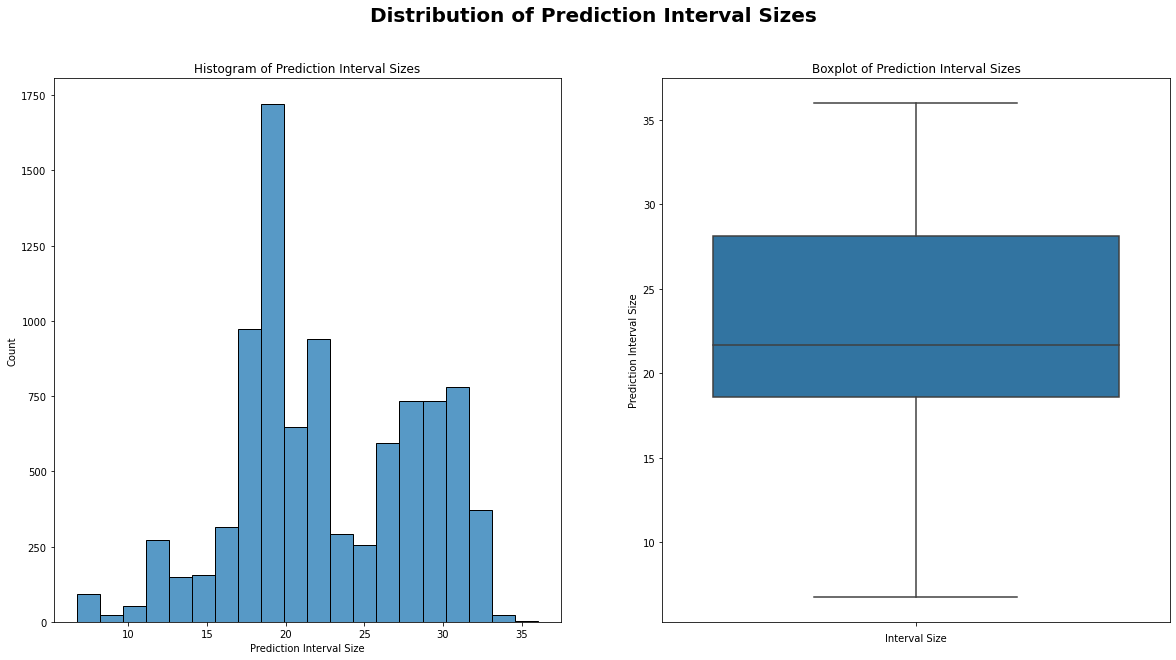

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Task 1: Plot histogram using sns
sns.histplot(data=results_df, x='Prediction_Interval_Size', bins=20, ax=ax[0])
ax[0].set_xlabel('Prediction Interval Size')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of Prediction Interval Sizes')

# Task 2: Plot boxplot using sns
sns.boxplot(data=results_df, y='Prediction_Interval_Size', ax=ax[1])
ax[1].set_xlabel('Interval Size')
ax[1].set_ylabel('Prediction Interval Size')
ax[1].set_title('Boxplot of Prediction Interval Sizes')

# Add overall title
fig.suptitle('Distribution of Prediction Interval Sizes', fontsize=20, weight='bold')

plt.show()


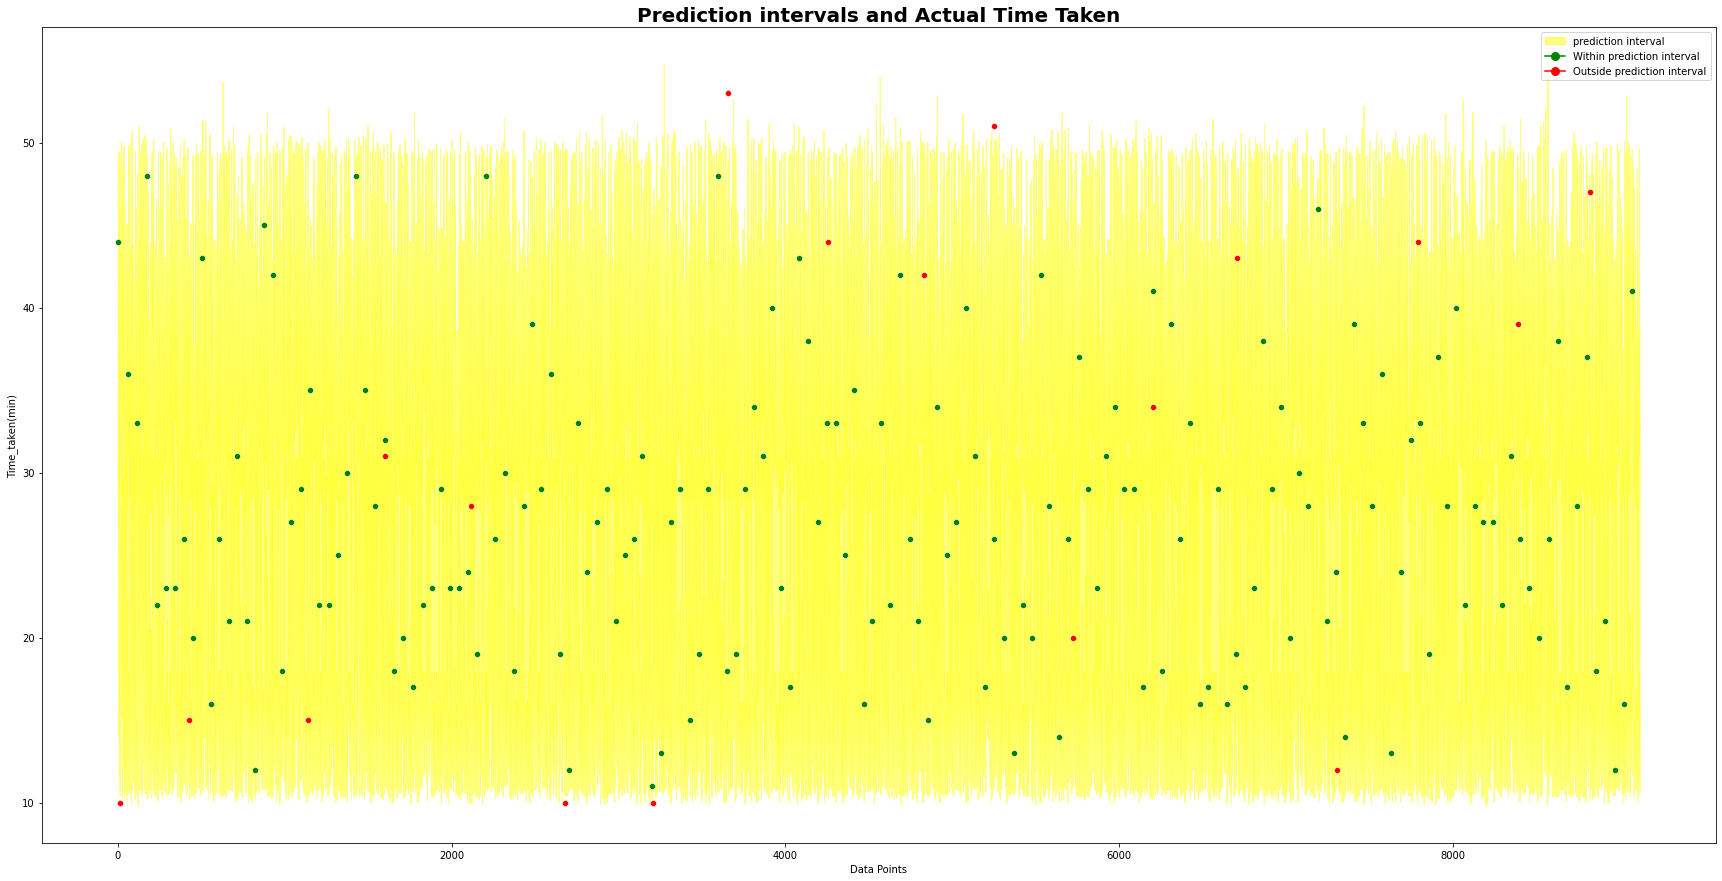

In [16]:
# percentage of data points to plot
percentage_to_plot = 0.02 

# set figure size
plt.figure(figsize=(30, 15))

# Plot prediction interval with yellow fill color
plt.fill_between(results_df.index, results_df['Lower Bound'], results_df['Upper Bound'], color='yellow', alpha=0.5)

# Plot time taken dots
within_interval = results_df['Within_Prediction_Interval'] == 'within'
sns.scatterplot(data=results_df[within_interval][::int(1/percentage_to_plot)], x=results_df.index[within_interval][::int(1/percentage_to_plot)], y='Time_taken(min)', color='green')
sns.scatterplot(data=results_df[~within_interval][::int(1/percentage_to_plot)], x=results_df.index[~within_interval][::int(1/percentage_to_plot)], y='Time_taken(min)', color='red')

# Add legend
plt.legend(handles=[plt.Rectangle((0,0),1,1, color='yellow', alpha=0.5, label='prediction interval'), plt.Line2D([0], [0], marker='o', color='green', label='Within prediction interval', markerfacecolor='green', markersize=8), plt.Line2D([0], [0], marker='o', color='red', label='Outside prediction interval', markerfacecolor='red', markersize=8)])

plt.xlabel('Data Points')
plt.ylabel('Time_taken(min)')
plt.title('Prediction intervals and Actual Time Taken', fontsize=20, weight='bold')
plt.show()


# END